<a href="https://colab.research.google.com/github/BhuBi347/Stat-229352/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [ ]:
train_size = int(0.8 * len(dataset)) #กำหนดขนาดเฉยๆง่าวๆเลย
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #ตัวแบ่งของจีงงง

In [ ]:
print(train_size)
print(val_size)

96
24


#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
train_loader

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

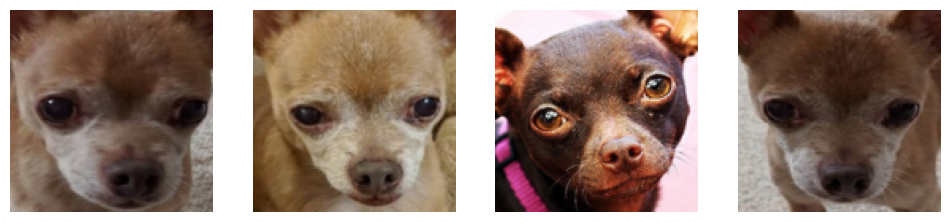

tensor([0, 0, 0, 0])


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

In [ ]:
X[0]

array([[[0.29411766, 0.11764706, 0.09411765],
        [0.28627452, 0.11764706, 0.09019608],
        [0.2784314 , 0.11764706, 0.09019608],
        ...,
        [0.22745098, 0.09803922, 0.07450981],
        [0.22745098, 0.09803922, 0.07843138],
        [0.21960784, 0.09019608, 0.07058824]],

       [[0.29411766, 0.11764706, 0.09411765],
        [0.2901961 , 0.12156863, 0.09411765],
        [0.28235295, 0.12156863, 0.09019608],
        ...,
        [0.22745098, 0.09803922, 0.07450981],
        [0.22352941, 0.09411765, 0.07450981],
        [0.21176471, 0.08235294, 0.06666667]],

       [[0.2901961 , 0.11372549, 0.09019608],
        [0.2901961 , 0.12156863, 0.09411765],
        [0.2901961 , 0.12156863, 0.09411765],
        ...,
        [0.22745098, 0.09019608, 0.07450981],
        [0.22352941, 0.08627451, 0.07450981],
        [0.22745098, 0.09019608, 0.08235294]],

       ...,

       [[0.68235296, 0.6431373 , 0.60784316],
        [0.69411767, 0.64705884, 0.6117647 ],
        [0.6784314 , 0

In [ ]:
y

tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(128 * 128 * 3, 1)
    self.activation = nn.Sigmoid()


  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.activation(x)
    return x


### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(X)
y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [ ]:
for param in model.parameters():
  print(param.grad)

tensor([[0.0559, 0.0549, 0.0508,  ..., 0.0508, 0.0453, 0.0418]])
tensor([0.1000])


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7bda1fab8f20>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Manually update the weights using the gradient descent rule


# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.6931471228599548]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

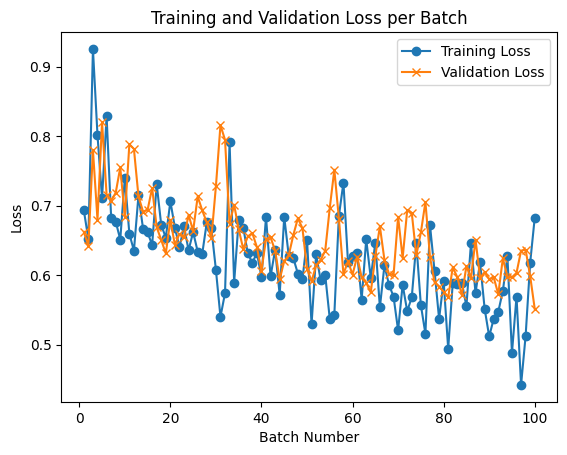

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [ ]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

In [ ]:
class MultiLayerNetwork(nn.Module):
    def __init__(self):
        super(MultiLayerNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 128 * 3, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
loss_history = {}
num_epochs = 20

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = MultiLayerNetwork()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        for X, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
        train_losses.extend(epoch_train_losses)


        model.eval()
        epoch_val_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                y_hat = y_hat[:, 0]
                y = y.to(torch.float32)
                val_loss = criterion(y_hat, y)
                epoch_val_losses.append(val_loss.item())
        val_losses.extend(epoch_val_losses)

    loss_history[lr] = {'train_losses': train_losses, 'val_losses': val_losses}


Training with learning rate: 0.01
Training with learning rate: 0.001
Training with learning rate: 0.0001
Training with learning rate: 1e-05


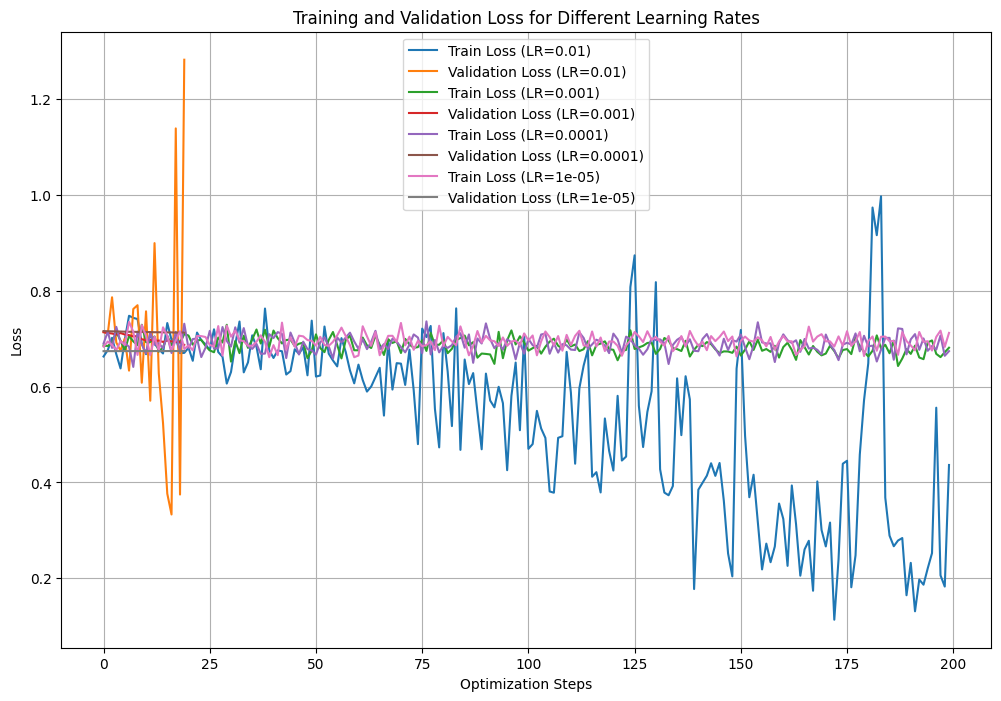

In [ ]:
plt.figure(figsize=(12, 8))
for lr, losses in loss_history.items():
    plt.plot(losses['train_losses'], label=f'Train Loss (LR={lr})')
    plt.plot(losses['val_losses'], label=f'Validation Loss (LR={lr})')

plt.title('Training and Validation Loss for Different Learning Rates')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Select the model trained with the best learning rate (1e-3)
# Re-initialize the model and load weights if necessary, here we assume the model with 1e-3 LR was the last one trained and available.
# If not, you would need to save and load the state_dict for the best model.
# For this exercise, we will re-train the model with the best learning rate for clarity.

best_lr = 1e-3
model = MultiLayerNetwork()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr)
num_epochs = 20

print(f"Re-training with best learning rate: {best_lr}")

for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)
            val_loss = criterion(y_hat, y)


# Evaluate the model on the test set
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        predicted_labels = (y_hat > 0.5).float()
        correct_predictions += (predicted_labels == y).sum().item()
        total_samples += y.size(0)

accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

Re-training with best learning rate: 0.001
Test Accuracy: 0.6667


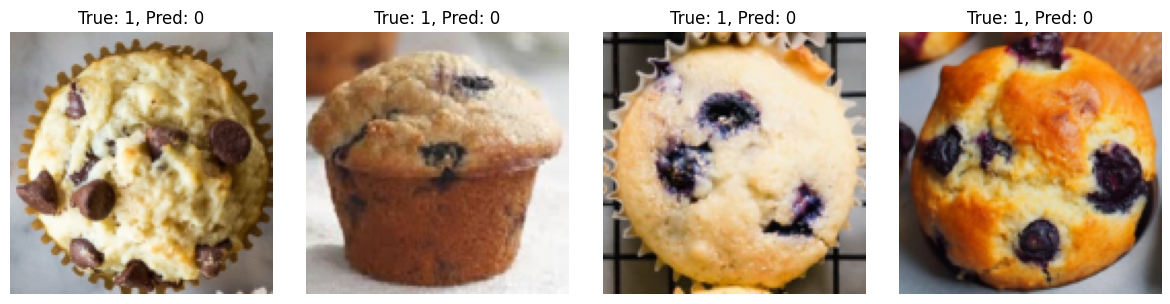

In [ ]:
model.eval()
misclassified_indices = []

with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        predicted_labels = (y_hat > 0.5).float()

        incorrect_indices = (predicted_labels != y).nonzero(as_tuple=True)[0]
        misclassified_indices.extend(incorrect_indices.tolist())

# Select at least four misclassified images (or all if less than four)
num_to_display = min(len(misclassified_indices), 4)
display_indices = misclassified_indices[:num_to_display]

fig, axes = plt.subplots(1, num_to_display, figsize=(3 * num_to_display, 3))

if num_to_display == 1:
    axes = [axes] # Make it an iterable for consistent indexing

for i, idx in enumerate(display_indices):
    # Retrieve the image and true label from the test dataset
    img, true_label = test_dataset[idx]

    # Convert the image tensor to a NumPy array and transpose dimensions for display
    img_np = img.numpy().transpose(1, 2, 0)

    # Get the predicted label for this image
    predicted_label = (model(img.unsqueeze(0)).squeeze() > 0.5).item()

    axes[i].imshow(img_np)
    axes[i].set_title(f'True: {true_label}, Pred: {int(predicted_label)}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y_filtered are defined
# X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.2, random_state=42)